# CNN 설계


In [34]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torchvision.utils import make_grid
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

In [35]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# !pip install kaggle --upgrade
# os.environ['KAGGLE_USERNAME'] = 'jungyuchoi'
# os.environ['KAGGLE_KEY'] = '9431599f2458bdba977477e62d1dd272'
# !kaggle datasets download -d ananthu017/emotion-detection-fer
# !unzip '*.zip'

In [38]:
!ls
torch.cuda.empty_cache()
import gc
gc.collect()

drive  emotion-detection-fer.zip  sample_data  test  train


4760

## 하이퍼파라미터 

In [39]:
EPOCHS     = 50
BATCH_SIZE = 200
MAX_LR = 0.008

## 데이터셋 불러오기

torch.Size([200, 1, 48, 48])
tensor([4, 4, 2, 5, 4, 4, 2, 4, 0, 6, 2, 3, 3, 3, 2, 3, 3, 2, 5, 3, 4, 6, 5, 3,
        4, 3, 4, 5, 4, 2, 4, 2, 5, 3, 5, 3, 0, 2, 2, 5, 3, 0, 6, 0, 2, 6, 4, 5,
        3, 6, 4, 5, 3, 4, 3, 4, 6, 5, 2, 3, 2, 5, 2, 6, 6, 6, 0, 0, 2, 3, 4, 4,
        5, 2, 6, 4, 3, 4, 4, 5, 3, 5, 5, 6, 4, 3, 0, 2, 6, 3, 2, 0, 3, 2, 3, 3,
        5, 6, 6, 0, 3, 5, 2, 0, 5, 3, 3, 5, 3, 3, 0, 5, 2, 4, 3, 6, 4, 3, 5, 5,
        5, 0, 0, 1, 0, 0, 6, 4, 3, 3, 0, 6, 5, 3, 3, 3, 2, 4, 0, 6, 3, 6, 3, 5,
        2, 4, 3, 3, 5, 6, 0, 3, 5, 0, 4, 5, 4, 3, 5, 3, 4, 5, 0, 3, 5, 6, 6, 3,
        6, 0, 4, 6, 3, 3, 3, 5, 2, 3, 3, 3, 0, 3, 0, 3, 3, 0, 4, 0, 3, 3, 0, 4,
        4, 5, 5, 4, 2, 4, 3, 5])


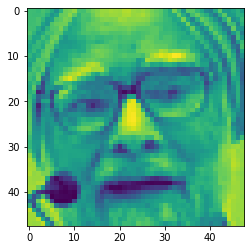

In [40]:
trans = transforms.Compose([
                            transforms.Grayscale(),
                            # transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(30),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))])

train_data = torchvision.datasets.ImageFolder(root='./train', transform=trans)
test_data = torchvision.datasets.ImageFolder(root='./test', transform=trans)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = True)

classes = ['neutral', 'fearful', 'sad', 'happy', 'surprised', 'angry', 'disgusted']

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
img = Image.open('./train/angry/im1.png')
plt.imshow(np.asarray(img))
print(labels)

## 모델



In [41]:
# 미리 훈련된 ResNet 모델을 다운로드하고 불러옴
# torchvision.models 참고

import torchvision.models as models

# model = models.resnet50(pretrained=True)
# print(model) # 불러온 모델 구조 확인

class Model(nn.Module):
    def __init__(self):
      super(Model, self).__init__()
      self.conv1 = nn.Conv2d(1, 16, 3)
      self.conv2 = nn.Conv2d(16, 32, 3)
      self.conv3 = nn.Conv2d(32, 64, 3)
      self.conv4 = nn.Conv2d(64, 32, 3)
      self.fc1 = nn.Linear(2048, 1024)
      self.fc2 = nn.Linear(1024, 128)
      self.fc3 = nn.Linear(128, 7)
      self.batch_norm_16 = nn.BatchNorm2d(16)
      self.batch_norm_32 = nn.BatchNorm2d(32)
      self.batch_norm_64 = nn.BatchNorm2d(64)
      self.drop_out = nn.Dropout2d(p=0.3)

    def forward(self, x):
      
      x = F.relu(self.batch_norm_16(self.conv1(x)))
      x = F.relu(self.drop_out(F.max_pool2d(self.batch_norm_32(self.conv2(x)), 2)))
      x = F.relu(self.drop_out(F.max_pool2d(self.batch_norm_64(self.conv3(x)), 2)))
      x = F.relu(self.drop_out(self.batch_norm_32(self.conv4(x))))
      x = x.view(-1, 2048)

      x = F.relu(self.drop_out(self.fc1(x)))
      x = F.relu(self.drop_out(self.fc2(x)))
      x = self.fc3(x)

      return x

model = Model()

## 준비

In [42]:
model.to(DEVICE)
model.load_state_dict(torch.load('/content/drive/MyDrive/model/model.pt'))
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, MAX_LR, epochs=EPOCHS, steps_per_epoch=len(train_loader))

## 학습하기

In [43]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

## 테스트하기

In [44]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [45]:
# !cd /content/model

In [46]:

# torch.save(model.state_dict(), "/content/drive/MyDrive/model/model.pt")

## 학습

[1] Test Loss: 1.3049, Accuracy: 51.91%
[2] Test Loss: 1.3022, Accuracy: 50.77%
[3] Test Loss: 1.2701, Accuracy: 52.80%
[4] Test Loss: 1.2813, Accuracy: 53.05%
[5] Test Loss: 1.2514, Accuracy: 53.54%
[6] Test Loss: 1.2608, Accuracy: 53.26%
[7] Test Loss: 1.2511, Accuracy: 54.44%
[8] Test Loss: 1.2206, Accuracy: 54.25%
[9] Test Loss: 1.2219, Accuracy: 54.32%
[10] Test Loss: 1.2176, Accuracy: 55.04%
[11] Test Loss: 1.2264, Accuracy: 55.49%
[12] Test Loss: 1.2211, Accuracy: 56.05%
[13] Test Loss: 1.2187, Accuracy: 54.54%
[14] Test Loss: 1.2148, Accuracy: 55.34%
[15] Test Loss: 1.2065, Accuracy: 55.73%
[16] Test Loss: 1.2100, Accuracy: 55.25%
[17] Test Loss: 1.2091, Accuracy: 54.64%
[18] Test Loss: 1.1998, Accuracy: 55.07%
[19] Test Loss: 1.2048, Accuracy: 55.78%
[20] Test Loss: 1.1979, Accuracy: 55.41%
[21] Test Loss: 1.1897, Accuracy: 55.63%
[22] Test Loss: 1.2007, Accuracy: 55.10%
[23] Test Loss: 1.1947, Accuracy: 55.96%
[24] Test Loss: 1.1852, Accuracy: 56.13%
[25] Test Loss: 1.1827, A

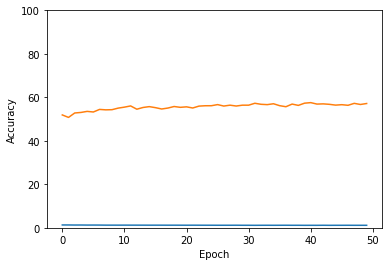

In [47]:
loss = []
accuracy = []
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    scheduler.step()
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    loss.append(test_loss)
    accuracy.append(test_accuracy)
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))
plt.plot(loss)
plt.plot(accuracy)
plt.ylim(0, 100)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

torch.save(model.state_dict(), "/content/drive/MyDrive/model/model_rotate.pt")